In [1]:
%load_ext autoreload
%autoreload 2
import os
os.chdir("../")

# CRF model

We consider the input image $I$ to be a graph $V$ with each node $v$ carrying pixel data (RGB). Then we can see about downsampling using e.g. SLIC.

We want to classify each node $v$ as foreground ($1$) or background ($-1$). For this, we will use a conditional random field (CRF) model specified over the nodes: the label likelihood factors as logistic regression given a latent variable $Z_v$ at node $v$:
$$
    p(l_v|Z_v;\theta) = g(l_v\theta^\intercal Z_v)\quad
    \text{where}\ g(u) = \frac{e^u}{e^u + 1}
$$
and $\theta$ is a parameter vector we learn over the set of examples.

The data likelihood is given by
$$
    \mathcal L(\theta; I) = \log\left(
        \sum_Z p(l|Z;\theta) p(Z|I)
    \right) =
    \log\left(\sum_Z
    \left[ \prod_{v\in V} 
            g(l_v\theta^\intercal Z_v)\right] p(Z|I)
    \right)
$$

In [45]:
import matplotlib.pyplot as plt
import cv2
import numpy as np

import glob

IMAGE_FOLDER = "data/train/images"
MASKS_FOLDER = "data/train/masks"

IMAGES = sorted(glob.glob(os.path.join(IMAGE_FOLDER, "*.jpg")))
MASKS = sorted(glob.glob(os.path.join(MASKS_FOLDER, "*.png")))

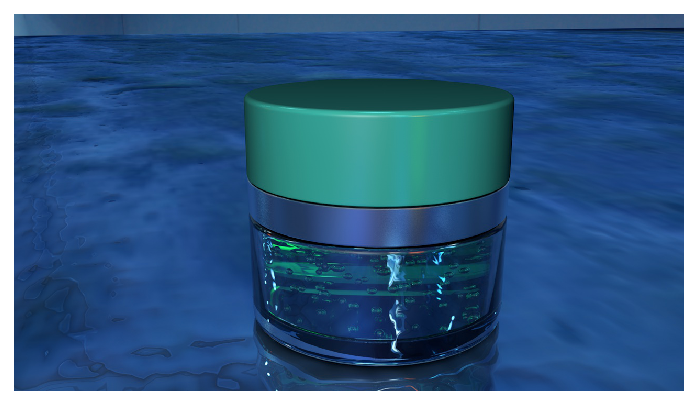

In [76]:
## Load an image
img = cv2.imread(IMAGES[22], cv2.COLOR_BGR2RGB)
mask = cv2.imread(MASKS[22])

plt.imshow(img)
plt.axis('off');

## Smart downsampling with SLIC

We define a SLIC superpixel model with $N=400$ components.

In [77]:
from fast_slic.avx2 import SlicAvx2

In [160]:
slic = SlicAvx2(num_components=1000, compactness=10)

In [161]:
assignments = slic.iterate(img)

In [162]:
from skimage import color
from skimage.segmentation import mark_boundaries

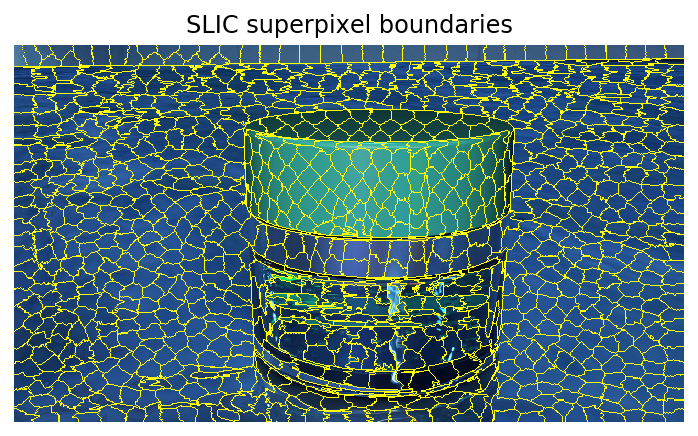

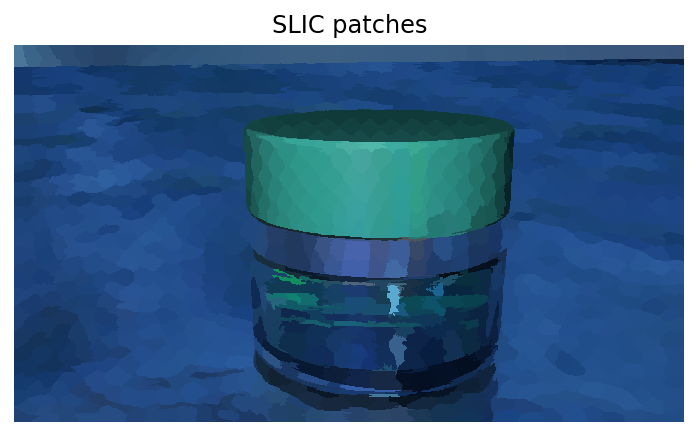

In [200]:
img_slic_boundaries = mark_boundaries(img, assignments)
img_slic = color.label2rgb(assignments, img, kind='avg')

plt.figure()
plt.title("SLIC superpixel boundaries")
plt.imshow(img_slic_boundaries)
plt.axis('off')

plt.figure()
plt.title("SLIC patches")
plt.imshow(img_slic)
plt.axis('off');

Now, we want to infer the labels of the SLIC cluster graph nodes.

In [164]:
## Recover the neighbors of each node
from utils import get_slic_graph

In [165]:
nodes, neighbors = get_slic_graph(slic, assignments)

In [166]:
print("NODE0:", nodes[0])
print("Neighbors:")
for n in neighbors[0]:
    print(nodes[n])

NODE0: {'number': 0, 'yx': (20.0, 34.0), 'color': (82.0, 123.0, 76.0), 'num_members': 385}
Neighbors:
{'number': 1, 'yx': (10.0, 57.0), 'color': (76.0, 125.0, 77.0), 'num_members': 218}
{'number': 80, 'yx': (72.0, 603.0), 'color': (57.0, 142.0, 55.0), 'num_members': 380}


In [170]:
def get_node_mask(mask, nodes):
    out = np.empty((len(nodes),), dtype=int)
    for i, n in enumerate(nodes):
        y, x = n['yx']
        y = int(y); x = int(x)
        out[i] = mask[y,x, 0] > 0
    return out

In [171]:
mask_nodes = get_node_mask(mask, nodes)

## Conditionally deterministic $Z$

Let's define the latent variable $Z$ to be a deterministic feature function of the node data $X$.

In this case, the likelihood function collapses to
$$
    \mathcal L(\theta; X) = \log\left(
        p(l|Z;\theta) p(Z|X)
    \right) =
    \sum_{v\in V} 
    \log g(\theta^\intercal Z_v)
    + \log p(Z|X)
$$

An easy choice to recover image data is to say that for all nodes $v$, $Z_v$ is the graph Laplacian at $v$.

In [172]:
def get_laplacian_node(nodes, neighbors, i: int):
    node = nodes[i]
    neigh = neighbors[i]
    col = np.asarray(node['color'])
    if len(neigh) > 0:
        lap = 1./len(neigh) * np.sum([
            np.asarray(nodes[j]['color']) - col
            for j in neigh], axis=0)
    else:
        lap = np.zeros((3,))
    return lap

def get_laplacian(node, neighbors):
    """Get full Laplacian features for each color channel."""
    return np.array([
        get_laplacian_node(nodes, neighbors, i)
        for i in range(len(nodes))
    ])

In [173]:
Z = get_laplacian(nodes, neighbors)

In [174]:
from scipy.special import expit

In [175]:
from scipy.optimize import minimize

In [176]:
def compute_mle(labels):

    def objective(theta):
        return -np.sum(np.log(expit(labels * Z @ theta)))

    def gradient(theta):
        weights = expit(-labels * Z @ theta)[:, None]
        return -np.sum(labels * weights * Z, axis=0)
    
    prog = minimize(objective, np.random.rand(3), jac=gradient)
    return prog

In [177]:
labels = mask_nodes[:, None] * 2 - 1

In [178]:
res = compute_mle(labels)

In [179]:
res

      fun: 471.01362385229504
 hess_inv: array([[0.00021576, 0.00043692, 0.00032675],
       [0.00043692, 0.00103365, 0.00075122],
       [0.00032675, 0.00075122, 0.00059154]])
      jac: array([ 7.01135238e-07, -2.10198793e-06,  1.18170850e-06])
  message: 'Optimization terminated successfully.'
     nfev: 23
      nit: 17
     njev: 23
   status: 0
  success: True
        x: array([-0.01444094, -0.00451683, -0.09971516])

In [180]:
def predict(theta):
    """Predict node label=1 probability."""
    return expit(Z @ theta)

In [181]:
prob_predict = predict(theta=res.x)

In [182]:
labels_predict = (prob_predict > .5).astype(int) * 2 - 1

In [184]:
from sklearn.metrics import accuracy_score

In [185]:
accuracy_score(labels, labels_predict)

0.756

In [191]:
def rebuild_mask(img, assignments, predict_labels):
    """Build a mask from the predicted labels and assignment matrix."""
    mask = np.zeros_like(img)
    for y in range(img.shape[0]):
        for x in range(img.shape[1]):
            if predict_labels[assignments[y, x]] > 0:
                mask[y, x, :] = 255
    return mask

In [193]:
mask_predict = rebuild_mask(img, assignments, labels_predict)

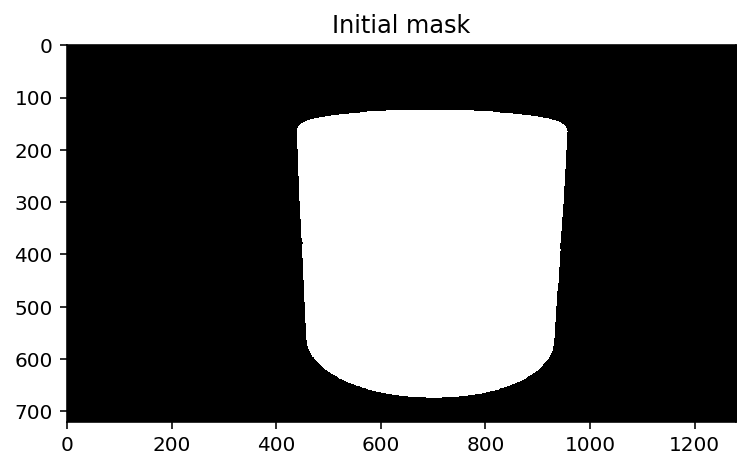

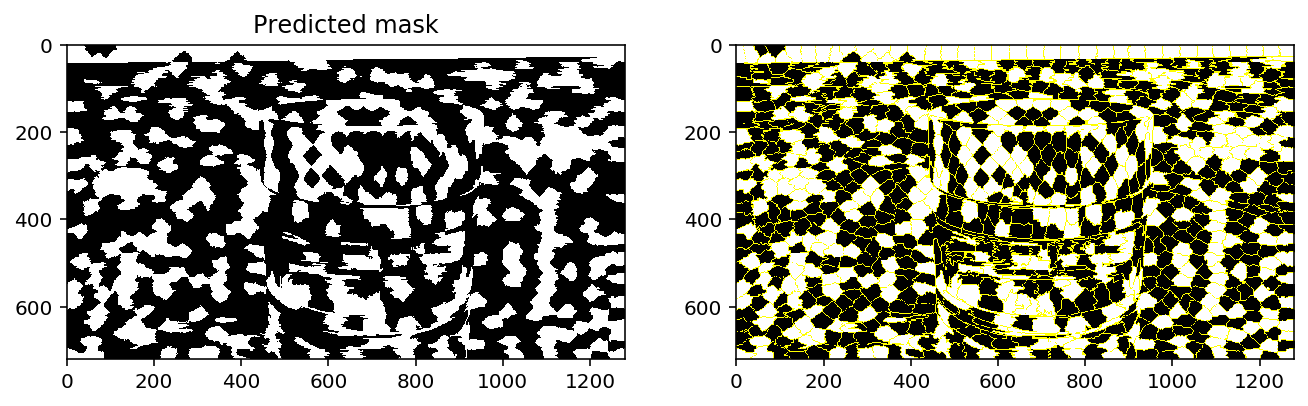

In [204]:
plt.figure()
plt.title("Initial mask")
plt.imshow(mask)


plt.figure(figsize=(11, 7))
mask_predict_boundaries = mark_boundaries(mask_predict, assignments)
plt.subplot(121)
plt.title("Predicted mask")
plt.imshow(mask_predict)
plt.subplot(122)
plt.imshow(mask_predict_boundaries)

## Stochastic latent $Z$

### EM algorithm